# Forecasting
This notebook contains steps for forecasting the percentage increase in Queens.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import pickle

from SCRIPT.plot_tools import *
from SCRIPT.eval_tools import *

from statsmodels.tsa.arima_model import ARIMA


In [3]:
with open('PKL/timeseries_queens_p.pkl', 'rb') as fp:
    df = pickle.load(fp)

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df.columns = df.columns.astype(str)

In [6]:
trdf = df.iloc[:int(len(df)*.8)]

In [7]:
tedf = df.iloc[int(len(df)*.8):]

For the initial univariate modeling, I will compare the top 5 zipcodes with the highest deviation from the average and one zipcode closest to the average.

In [8]:
select_zipcode = ['11101', '11693', '11692', '11694', '11103']

I'll run each model for each of the zipcodes. Then take the sum of squares across all predictions of all 5 zipcodes to compare between models.

# 1. SARIMA 
Our model has a seasonality and controllable stationarity. 

In [9]:
sel_df = trdf[select_zipcode[0]]

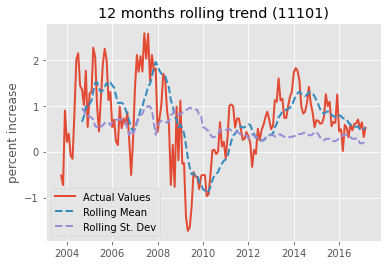

In [10]:
plot_moving_avg(sel_df, 12, select_zipcode[0])

In [11]:
run_dickyey_fuller(sel_df, select_zipcode[0])

Null Rejected (p = 0.0396). 11101 time series is stationary


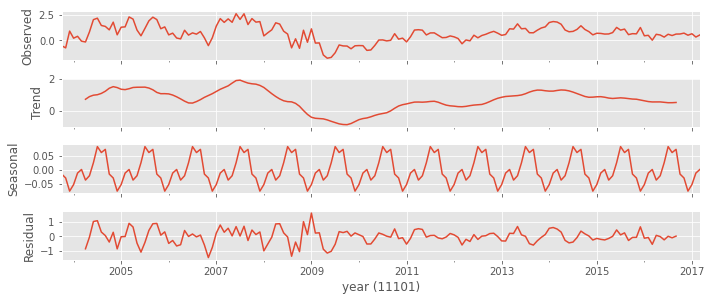

In [12]:
plot_decomposition(sel_df, select_zipcode[0])

Time series is stationary but shows seasonality.

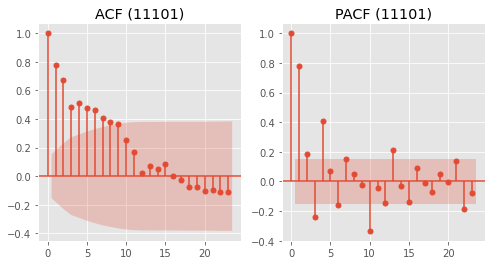

In [13]:
def_acf_pacf(sel_df, select_zipcode[0])

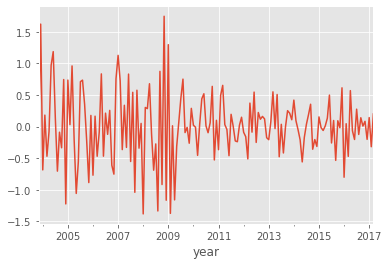

In [14]:
plot_basic(sel_df.diff(1)[1:])

In [15]:
run_dickyey_fuller(sel_df.diff(1)[1:], select_zipcode[0])

Null Rejected (p = 0.0044). 11101 time series is stationary


### ARIMA

In [67]:
# 1,1 ARMA
arma = ARIMA(pd.DataFrame(sel_df), order=(1,0,1)) # ARMA model
model = arma.fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                  11101   No. Observations:                  162
Model:                     ARMA(1, 1)   Log Likelihood                -119.253
Method:                       css-mle   S.D. of innovations              0.504
Date:                Mon, 05 Oct 2020   AIC                            246.506
Time:                        16:37:37   BIC                            258.857
Sample:                    10-01-2003   HQIC                           251.521
                         - 03-01-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6244      0.212      2.951      0.004       0.210       1.039
ar.L1.11101     0.8498      0.050     16.845      0.000       0.751       0.949
ma.L1.11101    -0.1726      0.090     -1.925    

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


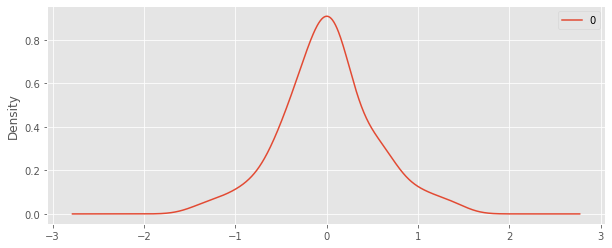

In [63]:
res = pd.DataFrame(model.resid)
res.plot(kind='kde')
plt.show()

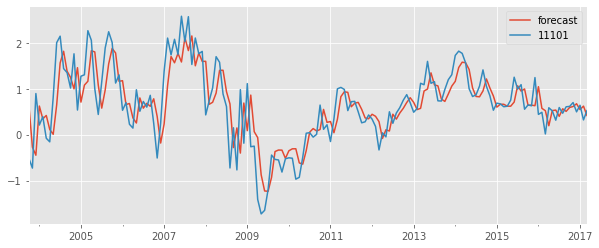

In [64]:
model.plot_predict()
plt.show()

### ARIMA

In [65]:
# 1,1 ARMA
arma = ARIMA(pd.DataFrame(sel_df), order=(1,1,1)) # ARMA model
model = arma.fit()
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.11101   No. Observations:                  161
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -115.187
Method:                       css-mle   S.D. of innovations              0.494
Date:                Mon, 05 Oct 2020   AIC                            238.375
Time:                        16:37:09   BIC                            250.700
Sample:                    11-01-2003   HQIC                           243.379
                         - 03-01-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0073      0.034      0.216      0.829      -0.059       0.073
ar.L1.D.11101    -0.8321      0.066    -12.654      0.000      -0.961      -0.703
ma.L1.D.11101     0.5854      0.080     

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
def get_rmse()

In [ ]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(CO2, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(CO2,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue